In [1]:
# CBF imports
import scipy
import numpy as np
import matplotlib.patches as pat
import matplotlib.pyplot  as plt
from data      import make_rectangle, insert_shape, plot_data, plot_angle_data, get_gparams
from agent     import Agent
from controls  import hjb_controls, hjb_controls_parallel
from rbf       import get_h, get_h_curr
from optim     import get_learning_cbfs_lagrangian_hj, get_learning_cbfs_lagrangian_hj_optim, cvx_train_cbf, clarabel_solve_cbf, fit_cbf_w_inv, gradient_descent
from utils     import plot_cbf, plot_angles, _plot_angles, quad_plot, union, intersection, difference

# HJB imports 
import jax
import jax.numpy            as jnp
import matplotlib.animation as anim
import matplotlib.pyplot    as plt
import plotly.graph_objects as go
import hj_reachability      as hj
from IPython.display import HTML

%load_ext autoreload
%autoreload 2

x,y spacing: 0.14677419354838708
theta spacing: 0.3141592653589793
X_0 GRID INFORMATION
 domain: [ -2.275 , 2.275 ]
 n: 32 
 density: 0.1421875
X_1 GRID INFORMATION
 domain: [ -2.275 , 2.275 ]
 n: 32 
 density: 0.1421875
X_2 GRID INFORMATION
 domain: [ 0 , 6.283185307179586 ]
 n: 20 
 density: 0.3141592653589793


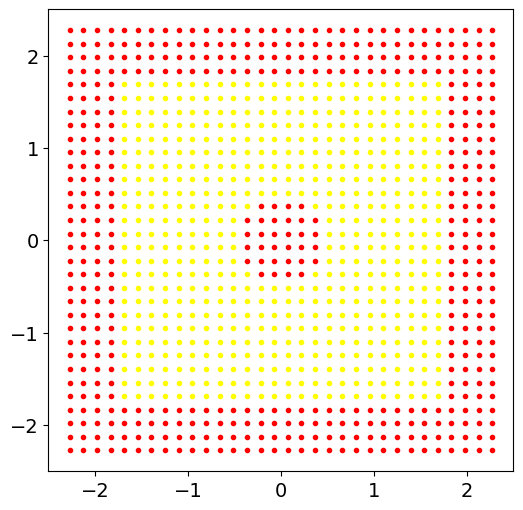

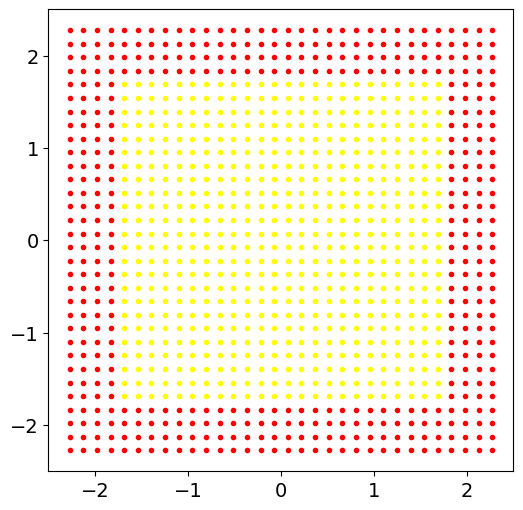

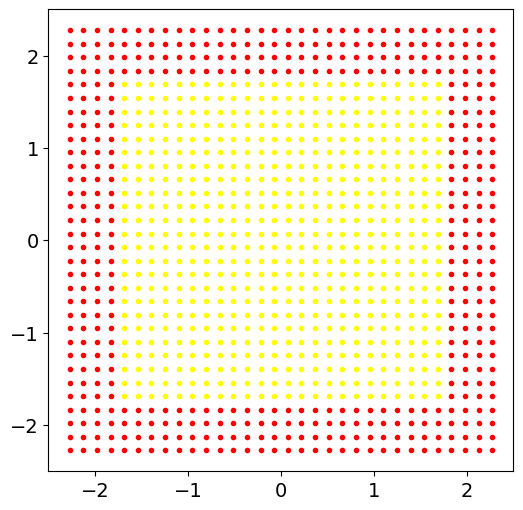

In [2]:
#########################
### Data Construction ###
#########################

width         = 3.5
density       = 50
unsafe_margin = 0.3
thn           = 20

# make grid and obstacles
obs_funcs = []
grid, params, obs_dict, is_obs_grid = make_rectangle(height=width, width=width, density=density, unsafe_margin=unsafe_margin, center=(0,0), return_params=True)
#obs_dict = insert_shape(np.array([0,  1.5]), grid, obs_dict, shape='circle', scale=0.75, theta=0)
obs_dict, is_obs_circ = insert_shape(np.array([0, 0]), grid, obs_dict, shape='circle', scale=0.50, theta=0)
obstacles = np.array([pt for pt in grid if obs_dict[tuple(np.round(pt, 3))] != 0])
obs_funcs.append(is_obs_grid)
obs_funcs.append(is_obs_circ)

#### DEBUG: USE TO VALIDATE CHECK_OBS ###
'''
from data import check_obs
for pt in grid:
    if check_obs(pt, obs_funcs):
        plt.plot(pt[0], pt[1], marker='.', color="r", linestyle="none")
    else:
        plt.plot(pt[0], pt[1], marker='.', color="yellow", linestyle="none")
plt.show()
'''

# grids for centers and unsafe samples
c_grid, c_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))
s_grid, s_obs_dict = make_rectangle(height=width, width=width, density=density/1, unsafe_margin=unsafe_margin, center=(0,0))


# initialize hjb grid
lo, hi, n, spacing = params
print("x,y spacing:", spacing)
lo = lo + (0       ,)
hi = hi + (2*jnp.pi,)
n  = n  + (thn     ,)
print("theta spacing:", 2*jnp.pi / thn)

for i in range(len(lo)):
    print("X_" + str(i) + " GRID INFORMATION\n", 
          "domain: [", lo[i], ",", hi[i], "]\n", 
          "n:", n[i],"\n", 
          "density:", (hi[i]-lo[i])/n[i])


hjb_grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(hj.sets.Box(lo, hi), n, periodic_dims=2)

plot_data(  grid,   obs_dict, size=6)
plot_data(c_grid, c_obs_dict, size=6)
plot_data(s_grid, s_obs_dict, size=6)

(1024, 2)
(32, 32, 20)


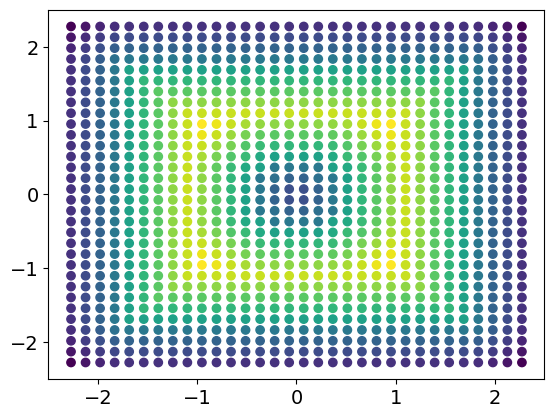

In [3]:
#####################################
### Make Signed Distance Function ###
#####################################

l = np.empty(hjb_grid.states.shape[:-1])

obs_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] != 0])
fre_coords = np.array([x for x in grid if obs_dict[tuple(np.round(x, 3))] == 0])

for i in range(n[0]):
    for j in range(n[1]):
        for k in range(n[2]):
            if obs_dict[tuple(np.round(np.array(hjb_grid.states[i, j, k, :-1]), 3))] != 0:
                l[i, j, k] = -np.min(np.linalg.norm(fre_coords - hjb_grid.states[i, j, k, :2], axis=1))
            else:
                l[i, j, k] =  np.min(np.linalg.norm(obs_coords - hjb_grid.states[i, j, k, :2], axis=1))

print(grid.shape)
print(l.shape)
plt.scatter(grid[:,0], grid[:,1], c=l[...,0].reshape(-1, 1))
plt.show()

In [4]:
############################
### Configure HJB Solver ###
############################

gamma  = 0.20
cbvf   = True
umax   = 0.40
utype  ="box"
V      = 0.10
l      = jnp.array(l)
values = l 
solver_settings = hj.SolverSettings.with_accuracy("very_high",
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube,
                                                  value_postprocessor      =hj.solver.static_obstacle(l))

In [5]:
####################################
### Solver PDE for final surface ###
####################################

dynamics = hj.systems.Bicycle(gamma=gamma, V=V, umax=umax)
time = 0.
target_time = -500
target_values = hj.step(solver_settings, dynamics, hjb_grid, time, values, target_time)

100%|##############################| 500.0000/500.0 [00:03<00:00, 125.56sim_s/s]


<Figure size 640x480 with 0 Axes>

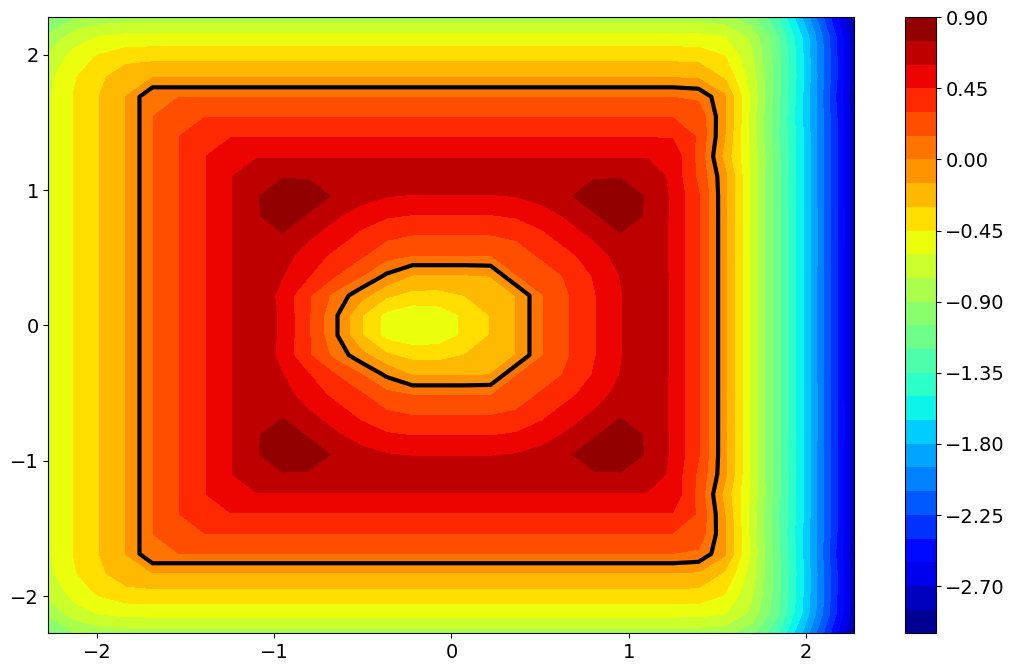

In [6]:
##########################
### Plot final surface ###
##########################

plt.jet()
plt.figure(figsize=(13, 8))
plt.contourf(hjb_grid.coordinate_vectors[0], hjb_grid.coordinate_vectors[1], target_values[:, :, 0].T, levels=30)
plt.colorbar()
plt.contour(hjb_grid.coordinate_vectors[0],
            hjb_grid.coordinate_vectors[1],
            target_values[:, :, 0].T,
            levels=0,
            colors="black",
            linewidths=3)

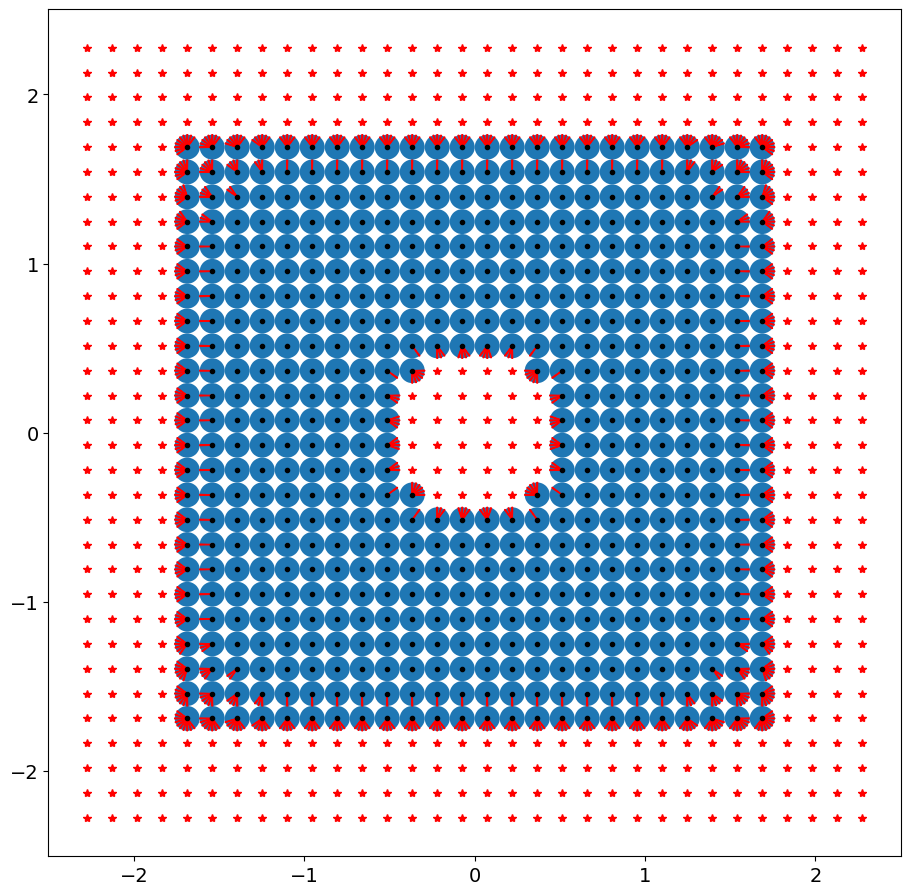

In [7]:
#######################################
### Plot V at each x,y using arrows ###
#######################################
ddegrees = 2

fig, ax = plt.subplots(figsize=(11,11))

plt.rc('xtick', labelsize=14)                                                
plt.rc('ytick', labelsize=14)                                                

for x in grid:                                                               
    if obs_dict[tuple(np.round(x, 3))] == 0:                               
        ax.plot(x[0], x[1], color="black", marker=".", linestyle="none")   
        A = pat.Annulus(x, spacing/2, spacing/2-0.01)
        ax.add_patch(A)
        pt = np.array([x[0], x[1], 0])
        idx = hjb_grid.nearest_index(pt)[:2]
        for i, Vtheta in enumerate(target_values[idx[0], idx[1]]):
            theta = hjb_grid.states[idx[0], idx[1], i][-1]
            if Vtheta <= 0:
                B = pat.Wedge(x, spacing/2, 360/(2*np.pi)*theta - ddegrees, 360/(2*np.pi)*theta + ddegrees, width=spacing/2, color='r')  
                ax.add_patch(B)
            #else:
            #    B = pat.Wedge(  x, s/2, 360/(2*np.pi)*theta - 1, 360/(2*np.pi)*theta + 1, width=s/2, color='b')  
            #    ax.add_patch(B)
    else:
        ax.plot(x[0], x[1], color="red"   , marker="*", linestyle="none") 

plt.show()

In [8]:
##############################
### Plot V(x, y, theta(t)) ###
##############################

vmin, vmax = target_values.min(), target_values.max()
levels = np.linspace(round(vmin), round(vmax), 5*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 target_values[:, :, i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, target_values.shape[-1], interval=50).to_html5_video())
plt.close(); animation

In [9]:
##########################################
### Solve for backwards reachable tube ###
##########################################

times = np.linspace(0, -500, 100)
initial_values = l
all_values = hj.solve(solver_settings, dynamics, hjb_grid, times, initial_values)

100%|##############################| 500.0000/500.0 [00:03<00:00, 144.39sim_s/s]


In [10]:
##########################################
### Visualize backwards reachable tube ###
##########################################

vmin, vmax = all_values.min(), all_values.max()
levels = np.linspace(round(vmin), round(vmax), 15*(round(vmax) - round(vmin) + 1))
fig = plt.figure(figsize=(13, 8))

def render_frame(i, colorbar=False):
    plt.contourf(hjb_grid.coordinate_vectors[0],
                 hjb_grid.coordinate_vectors[1],
                 all_values[i, :, :, 10].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    if colorbar:
        plt.colorbar()
    plt.contour(hjb_grid.coordinate_vectors[0],
                hjb_grid.coordinate_vectors[1],
                target_values[:, :, 10].T,
                levels=0,
                colors="black",
                linewidths=3)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, all_values.shape[0], interval=50).to_html5_video())
plt.close(); animation

In [137]:
###########################
### Agent Configuration ###
###########################

bf    = 31    # csrbf order
b     =-1.1#-0.5   # offset (-0.5)
s     = 1.00#1.00  #0.75# csrbf zeroing
nm    = 0.30  # nm * n_safe = number of neighbors to consider
pct   = 0.40  # num neighber percentile under which boundary
mult  = 4
utype = utype # defined w/ hjb above
umax  = umax  # defined w/ hjb above
gamma = gamma # defined w/ hjb above
jax_f = True
solver        ='CLARABEL'
sensor_radius = 1.1
rx            = sensor_radius + 0.2 # sample radius
rc            = sensor_radius # radius around scan in which centers are chosen
init_x        =-1.1
init_y        =-1.1
init_theta    = 0

# CHECK GAMMA -> 1/GAMMA
a = Agent(dynamics, np.array([init_x, init_y, init_theta]), grid, obs_dict, width         = width, 
                                                                            sensor_radius = sensor_radius,
                                                                            bf            = bf, 
                                                                            b             = b, 
                                                                            s             = s,
                                                                            utype         = utype,
                                                                            umax          = umax,
                                                                            gamma         = gamma,
                                                                            jax_f         = jax_f,
                                                                            solver        = solver,
                                                                            spacing       = spacing,
                                                                            obstacles     = obstacles)

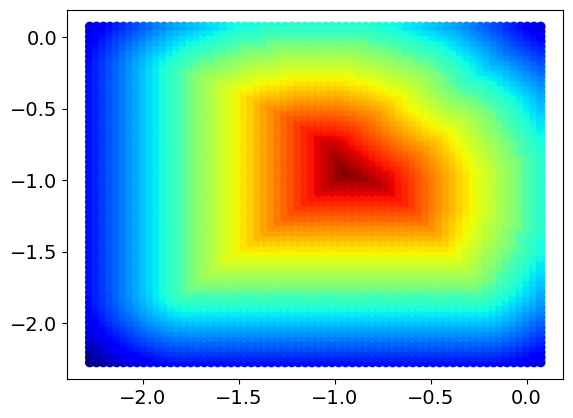

100%|###############################| 500.0000/500.0 [00:21<00:00, 23.74sim_s/s]


<Figure size 640x480 with 0 Axes>

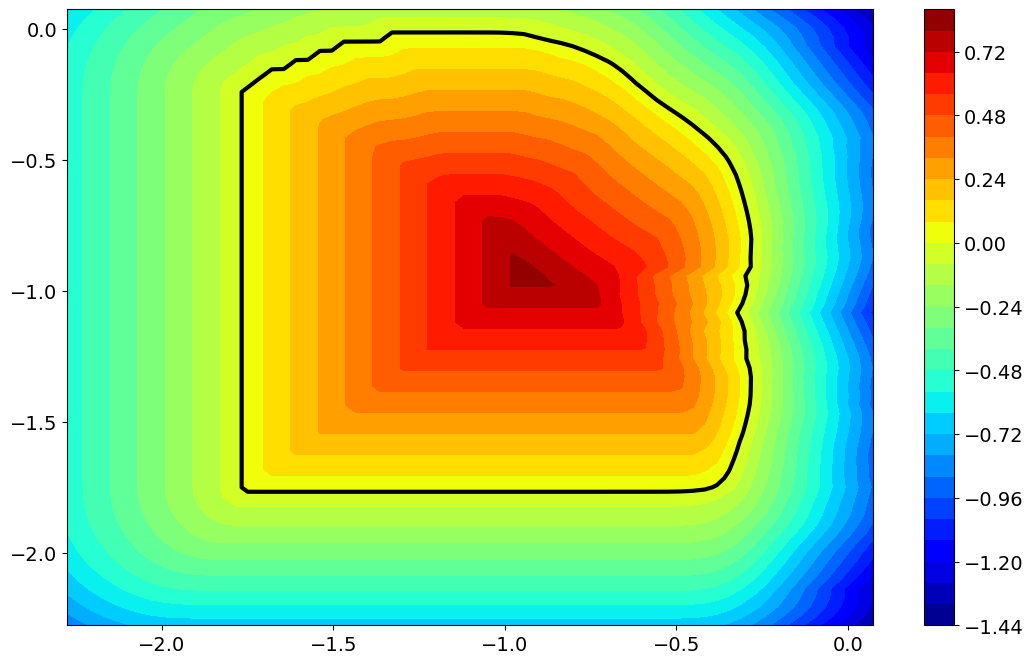

In [138]:
####################
### Initial scan ###
####################

# scan states 
pts_safe, pts_unsafe,\
             in_scan_f = a.scan(ret_in_scan_f=True) 
scan_funcs = [in_scan_f]
samples, gparams,\
is_obs_sample, x2pi_samp, x0_samp = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True, bicycle=True, boundary_condition=True)
sample_funcs = [is_obs_sample]
loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], thn, rx=rx, T=500, mult=mult)

In [139]:
vmin, vmax = loc_V.min(), loc_V.max()
#levels = np.linspace(round(vmin), round(vmax), 10*(round(vmax) - round(vmin) + 1))
levels = np.linspace(vmin, vmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(loc_hjb_grid.coordinate_vectors[0],
                 loc_hjb_grid.coordinate_vectors[1],
                 loc_V[:, :, i].T,
                 vmin=vmin,
                 vmax=vmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.contour(loc_hjb_grid.coordinate_vectors[0],
                loc_hjb_grid.coordinate_vectors[1],
                loc_V[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, loc_V.shape[-1], interval=50).to_html5_video())
plt.close()
animation

In [140]:
scan_safe, scan_unsafe,\
x2pi_scan, x0_scan = a.scan_hjb(loc_V, loc_hjb_grid, bicycle=True, boundary_condition=True)
n_safe             = len(scan_safe) #len(pts_safe)
x_buffer, x_safe   = a.make_buffer(scan_safe, int(nm * n_safe), pct, bicycle=True)

x2pi = np.vstack((x2pi_samp, x2pi_scan))
x0   = np.vstack((x0_samp, x0_scan))

# unsafe states 
if scan_unsafe.shape[0] != 0:
    x_unsafe = np.vstack((scan_unsafe, samples))
else: 
    x_unsafe = samples    

counts [426 447 450 ... 492 462 458]
pct 0.4


In [141]:
#######################
### Collect centers ###
#######################

C = []
for x in c_grid:
    if np.linalg.norm(x[:2] - a.pos[:2]) <= rc:
        C.append(x)
C = np.array(C)

tmp = []
for p in C:
    c = np.repeat(p.reshape(1, -1), hjb_grid.states.shape[2], axis=0)
    c = np.hstack((c, np.array(hjb_grid.coordinate_vectors[2]).reshape(-1, 1)))
    cend = np.array([p[0], p[1], 2*np.pi]).astype(np.float32)
    tmp.append(np.vstack((c,cend)))
C = np.vstack(tmp) 

a.centers.append(C)

dx = params[-1]
dth = abs(loc_hjb_grid.states[0,0,0,2]-hjb_grid.states[0,0,1,2])
print("ratio of subsequent theta gridpt dist to csrbf zeroing dist:\n",s/dth)
print("ratio of subsequent x gridpt dist to csrbf zeroing dist:\n",s/dx)
for i in range(2):
    print("X_" + str(i) + " GRID INFORMATION\n", 
          "domain: [", loc_hjb_grid.domain.lo[i], ",", loc_hjb_grid.domain.hi[i], "]\n", 
          "n:", (loc_hjb_grid.domain.hi[i] - loc_hjb_grid.domain.lo[i]) / spacing,"\n", 
          "density:", hjb_grid.states.shape[i]/(hjb_grid.domain.hi[i]-hjb_grid.domain.lo[i]))
print("X_" + str(2) + " GRID INFORMATION\n", 
      "domain: [", hjb_grid.domain.lo[2], ",", hjb_grid.domain.hi[2], "]\n", 
      "n:", (hjb_grid.domain.hi[2] - hjb_grid.domain.lo[2]) / spacing,"\n", 
      "density:", hjb_grid.states.shape[2]/(hjb_grid.domain.hi[2]-hjb_grid.domain.lo[2]))

sth = s/dx * dth
print("theta zeroing dist should be:", sth)
print("ratio of subsequent theta gridpt dist to modified csrbf zeroing dist:\n",sth/dth)
theta_scale = (n[2] * (hi[0] - lo[0])) / (n[0] * 2*np.pi)
print(theta_scale)
a.theta_scale = theta_scale #/ 4
print(a.theta_scale)
#1 / 2*np.pi 

#from optim import get_phiT
#phi = get_phiT(a)
#phi(np.array([0, 0, 0]), C)

ratio of subsequent theta gridpt dist to csrbf zeroing dist:
 3.1830988
ratio of subsequent x gridpt dist to csrbf zeroing dist:
 6.813186813186814
X_0 GRID INFORMATION
 domain: [ -2.275 , 0.073387094 ]
 n: 16.000002 
 density: 7.032967032967033
X_1 GRID INFORMATION
 domain: [ -2.275 , 0.073387094 ]
 n: 16.000002 
 density: 7.032967032967033
X_2 GRID INFORMATION
 domain: [ 0 , 6.283185307179586 ]
 n: 42.808515279685096 
 density: 3.183098861837907
theta zeroing dist should be: 2.1404257
ratio of subsequent theta gridpt dist to modified csrbf zeroing dist:
 6.813186
0.4525968694175774
0.4525968694175774


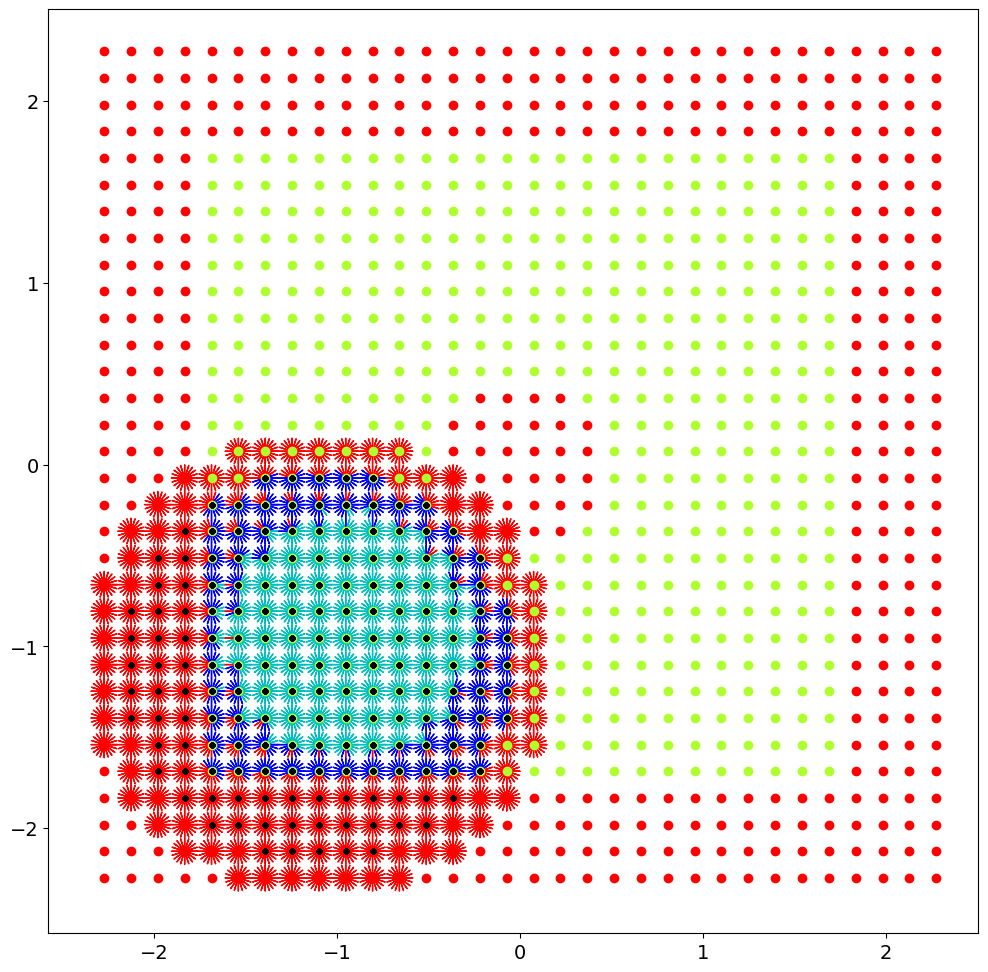

In [142]:
#############################
### Plot Initial CBF data ###
#############################

plot_angle_data(C, grid, obs_dict, spacing, safe=x_safe, buffer=x_buffer, unsafe=scan_unsafe, samples=samples)

In [143]:
###########################################
### Obtain controls from Value Function ###
###########################################

from tqdm import tqdm

u_safe = hjb_controls_parallel(a, x_safe, loc_hjb_grid, loc_V, verbose=True)
if x_buffer.shape[0] != 0:
    u_buffer = hjb_controls_parallel(a, x_buffer, loc_hjb_grid, loc_V)
else:
    u_buffer = np.array([]) 

'''
u_buffer = []
for x in tqdm(x_buffer):
    u_buffer.append(hjb_controls(a, x, loc_hjb_grid, loc_V))
u_buffer = np.array(u_buffer)

u_safe = []
for x in tqdm(x_safe):
    u_safe.append(hjb_controls(a, x, loc_hjb_grid, loc_V))
u_safe = np.array(u_safe)
'''

                                     CVXPY                                     
                                     v1.4.2                                    
(CVXPY) Aug 08 02:26:43 PM: Your problem has 1397 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 08 02:26:43 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 08 02:26:43 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 08 02:26:43 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Aug 08 02:26:43 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 08 02:26:43 PM: Compiling problem (target solver=CLARABEL)

'\nu_buffer = []\nfor x in tqdm(x_buffer):\n    u_buffer.append(hjb_controls(a, x, loc_hjb_grid, loc_V))\nu_buffer = np.array(u_buffer)\n\nu_safe = []\nfor x in tqdm(x_safe):\n    u_safe.append(hjb_controls(a, x, loc_hjb_grid, loc_V))\nu_safe = np.array(u_safe)\n'

In [144]:
##############################
### Initial CBF Parameters ###
##############################
    
gamma_safe   = 1.0
gamma_unsafe =-1.0
gamma_dyn    = 0.33
lam_safe     = 1
lam_dyn      = 1
lam_unsafe   = 1
lam_dh       = 0.0
lam_th       = 0.0
lam_sp       = 0

In [145]:

print(loc_hjb_grid.states.shape)
print(loc_V.shape)
print(loc_hjb_grid.interpolate(loc_V, C[0]))




(68, 68, 20, 3)
(68, 68, 20)
-0.378984


[[0.04953087 0.04215739 0.02784711 ... 0.         0.         0.        ]
 [0.04215739 0.04953087 0.04215739 ... 0.         0.         0.        ]
 [0.02784711 0.04215739 0.04953087 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.04953087 0.0421574  0.02784712]
 [0.         0.         0.         ... 0.0421574  0.04953087 0.04215738]
 [0.         0.         0.         ... 0.02784712 0.04215738 0.04953087]]
[-10.418698    -0.30858332  -5.2565002  ...  -8.302517   -11.685412
  11.428619  ]
gamma_safe: 1.0
gamma_dyn: 0.33
gamma_unsafe -1.0
lam safe 1
lam_dyn 1
lam_unsafe 1
lam_dh 0.0
lam_th 0.0
hmax 10
<PjitFunction of <function jax_get_learning_cbfs_lagrangian.<locals>.L at 0x7326f3e1cc10>>
it 0 loss: 6752.389
it 10 loss: 768.8236
it 20 loss: 419.26117
it 30 loss: 182.28763
it 40 loss: 109.37559
it 50 loss: 104.7772
it 60 loss: 92.12588
it 70 loss: 86.3862
it 80 loss: 83.45363
it 90 loss: 80.97482
it 100 loss: 78.96599


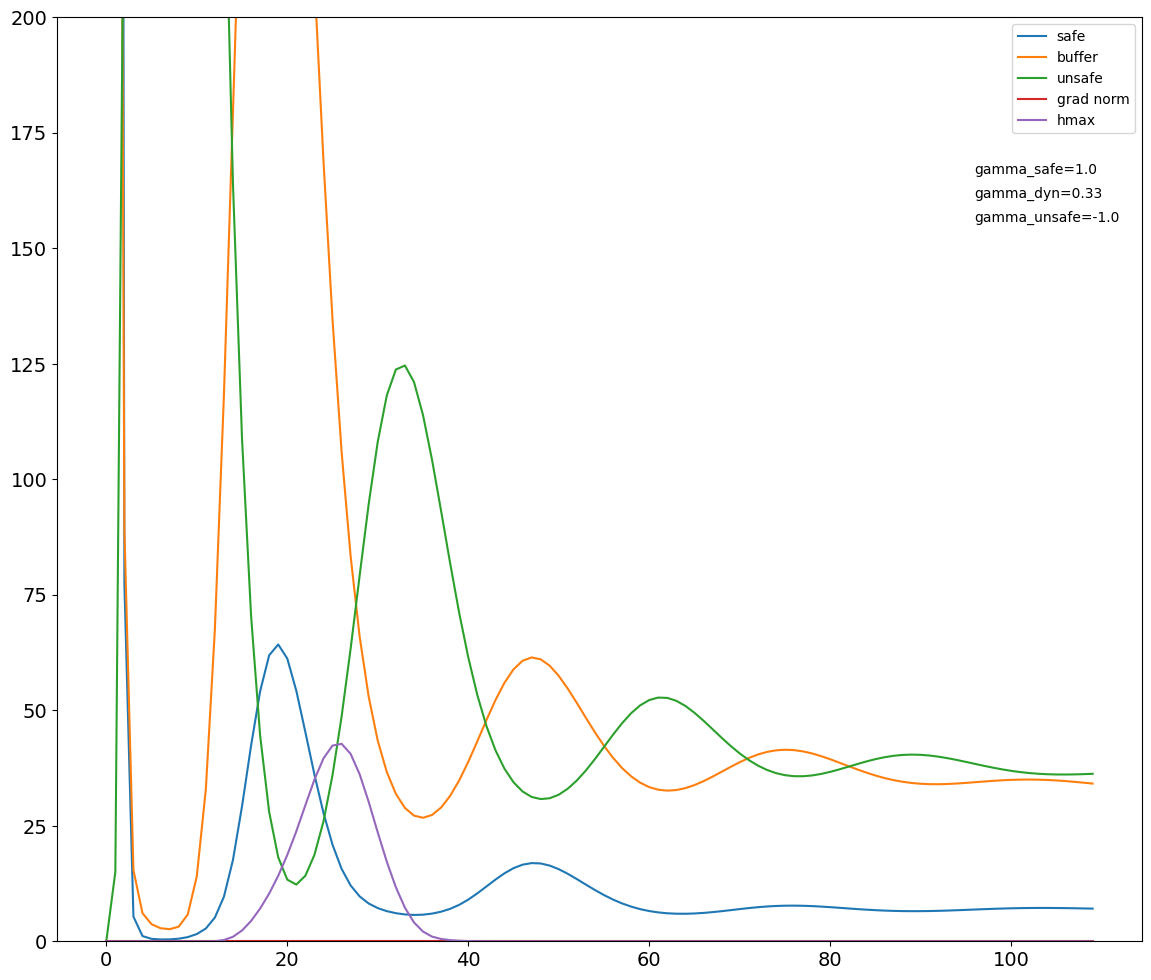

centers shape before:
(3717, 3)


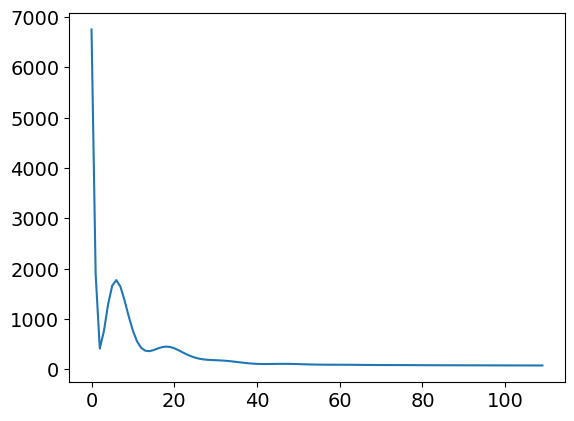

In [146]:
#########################
### Solve Initial CBF ###
#########################

# get h as a function of agent parameter
h = get_h(a)

#print(x2pi)
#print(x0)
#L = get_learning_cbfs_lagrangian_hj_optim(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, lam_safe, lam_dyn, lam_unsafe, lam_dh, gamma_safe, gamma_dyn, gamma_unsafe)
#theta, _, _ = scipy.optimize.fmin_l_bfgs_b(L, np.random.rand(C.shape[0], 1), approx_grad=False, iprint=50)
#theta = cvx_train_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, lam_dh=lam_dh, lam_sp=lam_sp, verbose=True)
#theta = np.array(clarabel_solve_cbf(a, x_safe.astype(np.float64), u_safe.astype(np.float64), x_buffer.astype(np.float64), 
#                                       u_buffer.astype(np.float64), x_unsafe.astype(np.float64), gamma_safe, gamma_dyn, gamma_unsafe))#,
#                                       x2pi=x2pi.astype(np.float64), x0=x0.astype(np.float64) ))
# prepare data 
#heta = np.array(clarabel_solve_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe))
#C = loc_hjb_grid.states.reshape(-1, 3)

interpv = jax.vmap(loc_hjb_grid.interpolate, in_axes=(None, 0))
b = interpv(loc_V, C)
theta = fit_cbf_w_inv(a, C, b)
print(theta)
it = 110; eps=1e-2; tol=1e-8; mu=0.90; hm=10
theta, loss = gradient_descent(a, theta, it, eps, mu, tol, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe,\
                               gamma_dyn, gamma_unsafe, lam_safe, lam_dyn, lam_unsafe, lam_dh, lam_th, hm, use_jax=True)
plt.plot(loss)

a.thetas.append(theta)
a.rectify_c_and_theta()

# initialize plotting objects
init_pos       = np.copy(a.pos)
curr_centers   = np.copy(np.array(a.centers))
curr_thetas    = np.copy(np.array(a.thetas))
curr_data      = np.copy(np.vstack((x_safe, x_buffer, x_unsafe)))
curr_traj      = np.copy(a.pos.reshape(-1, 3))
quad_plot_args =[(0, curr_centers, curr_thetas, curr_data)]
data_safe = np.vstack((x_buffer, x_safe))
data_unsafe = x_unsafe
all_C = C

In [147]:
print(theta.shape)
print(np.array(a.thetas).shape)
print(np.linalg.norm(theta)**2)

(3717,)
(1, 3717)
1466187.8165338188


num data 250000
partition 25000
remainder 0
(25000, 3)
(25000, 3)
(25000, 3)
(25000, 3)
(25000, 3)
(25000, 3)
(25000, 3)
(25000, 3)
(25000, 3)
(25000, 3)


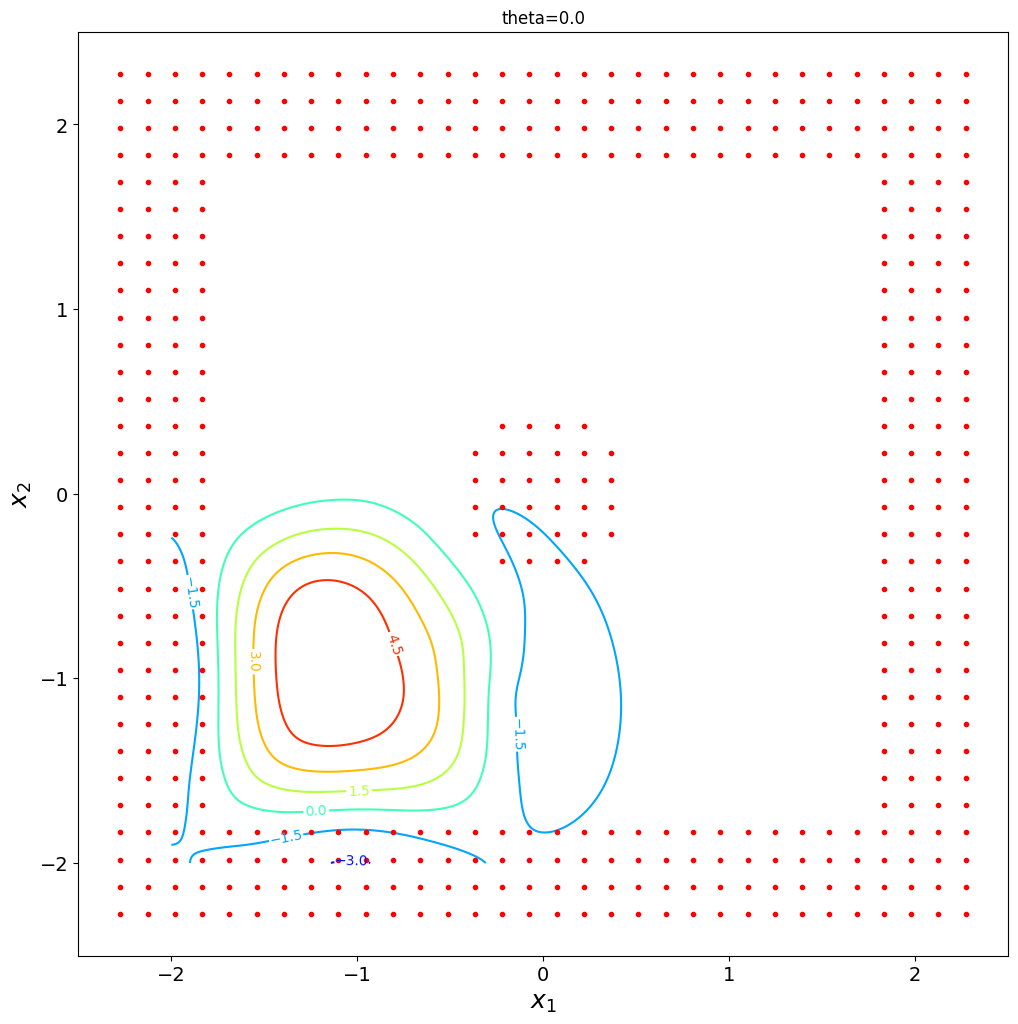

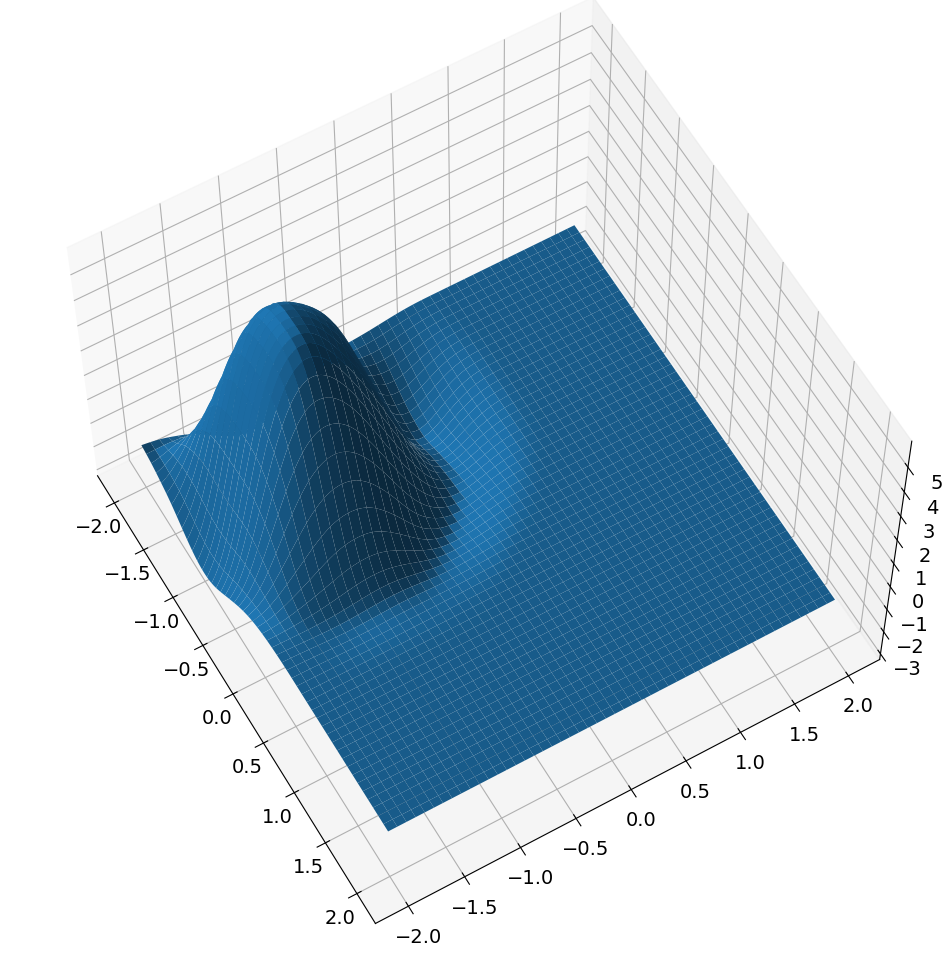

max h 5.849305
num data 20480
partition 2048
remainder 0
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)
(2048, 3)


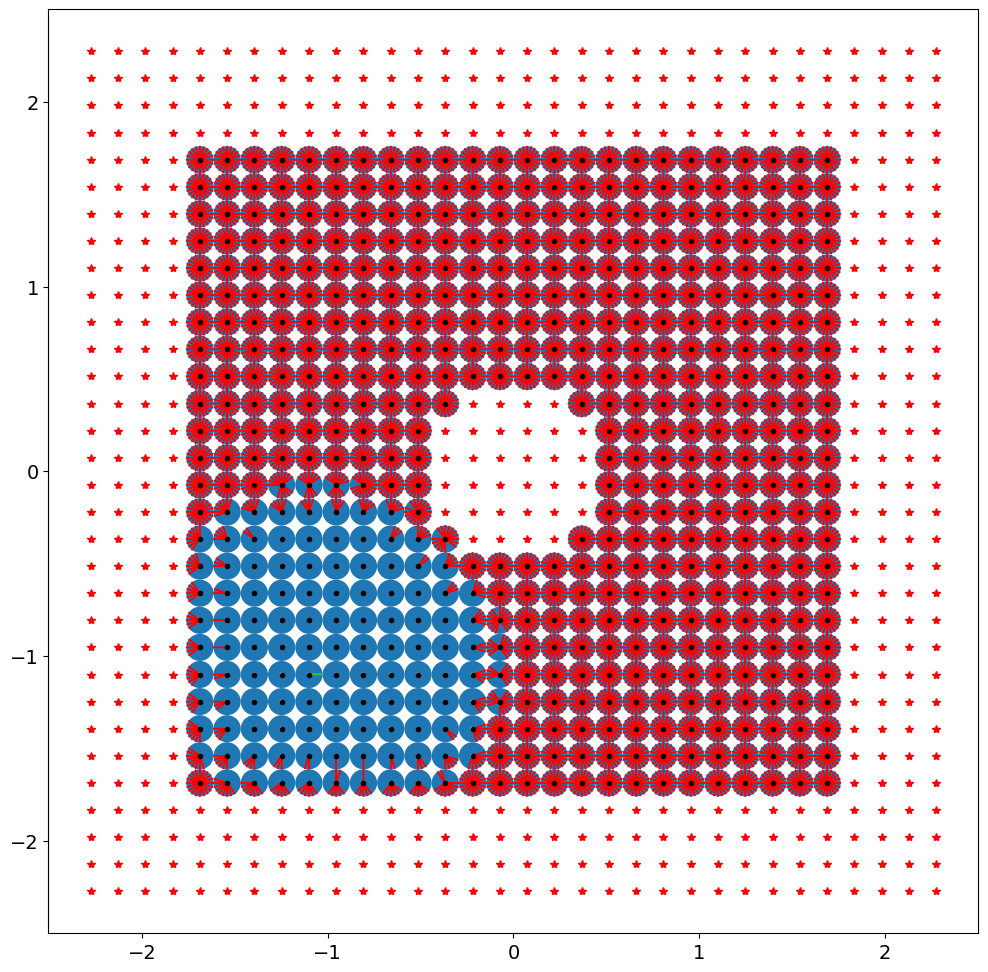

In [148]:
########################
### Plot Initial CBF ###
########################

h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), angle=a.pos[-1], obstacles=obstacles, N_part=10)
#a.thetas[-1] *= 1 / h_max
#h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), angle=a.pos[-1], obstacles=obstacles, N_part=10)
#h_max = plot_cbf(a, loc_hjb_grid.states.reshape(-1, 3)[np.newaxis,:], theta[np.newaxis, :], angle=a.pos[-1], obstacles=obstacles)
#h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), angle=2*np.pi, obstacles=obstacles)
plot_angles(a, grid, loc_hjb_grid, obs_dict, pos=a.pos, N_part=10)

In [149]:
##################################
### Configure Safe Exploration ###
##################################

DT   = 0.005   # numerical integration timestep
tol  = 0.000   # h-value at which to halt approach
eps  = 0.000
dx   = 0.5     # if |x'-x|<dx, approach again
tend = 80      # Duration of boundary approach
T    = 0.3     # MPC horizon (default timestep is 0.05)
N    = 3       # number of CBFs to learn

target: [ 1 -1  0]
position is [-1.1 -1.1  0. ]
start time is 0
safe control not found
num data 250000
partition 10000
remainder 0
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)
(10000, 3)


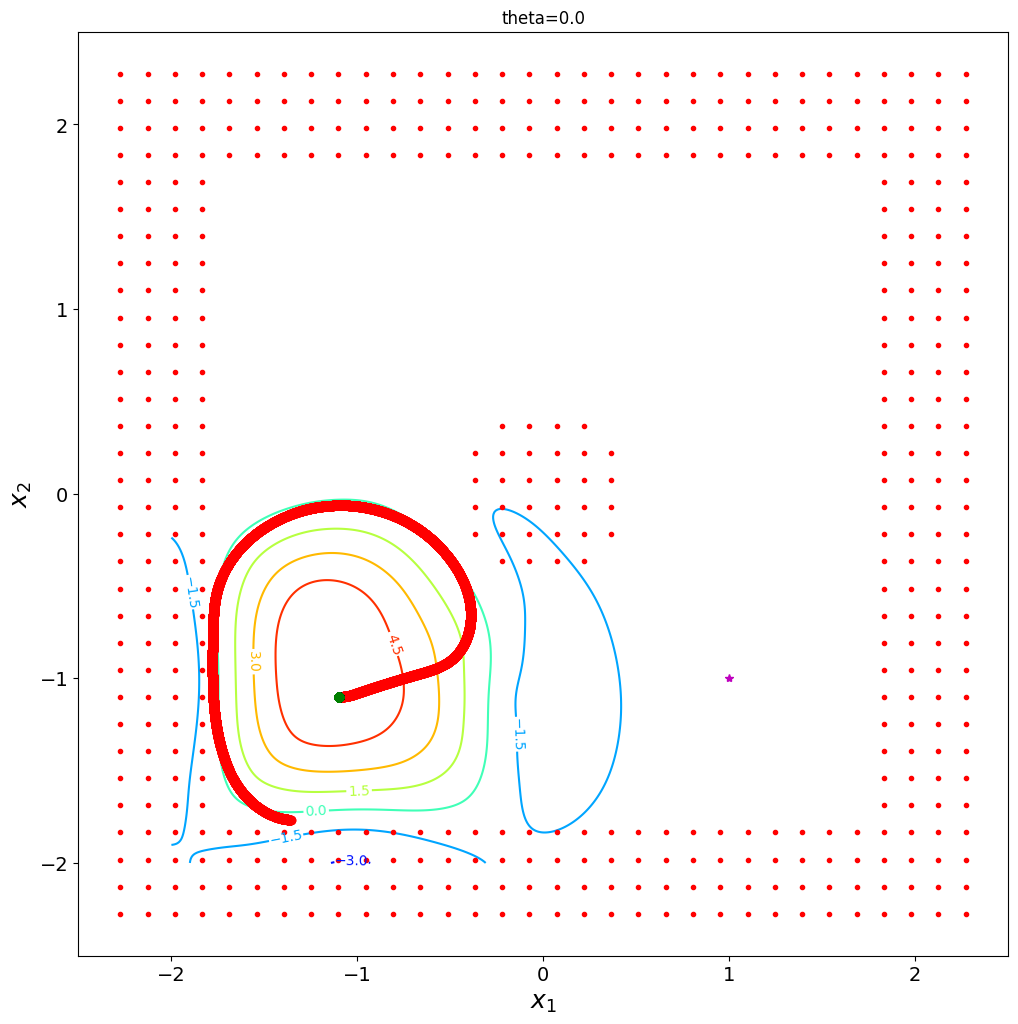

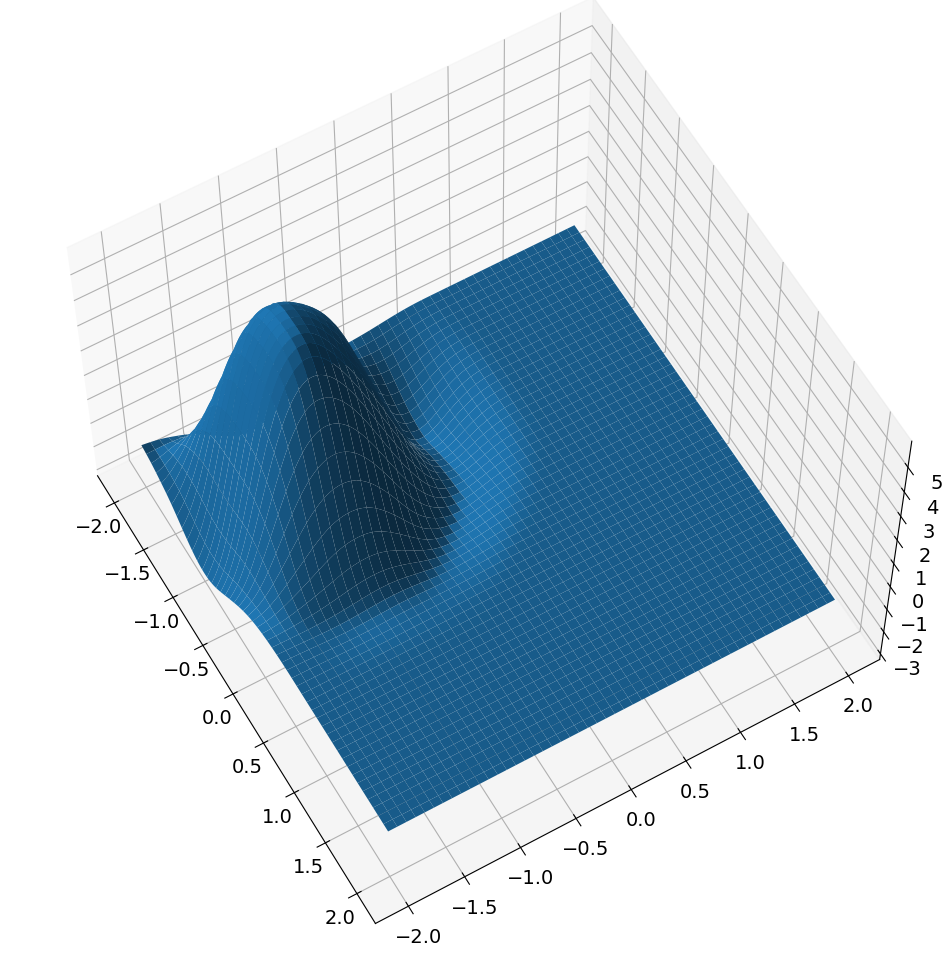

max h 5.849305
new position is [-1.35829747 -1.76616371  6.22767258]


IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [150]:
########################
### Safe Exploration ###
########################

targets   = [np.array([1, -1,       0]),
             np.array([1, -1,       0]),
             np.array([1,  1, np.pi/2]),
             np.array([1,  1, np.pi/2])]
#targets   = None

for i in range(N):
    ######################
    ### Go to boundary ###
    ######################
    
    prev_pos = a.pos  
    if targets is not None:
        print("target:", targets[i]) 
        traj,usig = a.goto(targets[i], T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps)  
        print("dx:", np.linalg.norm(a.pos - prev_pos))
    else: 
        while np.linalg.norm(a.pos - prev_pos) <= dx:    
            target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)  
            target_angle = np.array([2 * np.pi * np.random.rand()])
            target       = np.hstack((target_pos, target_angle)) 
            while h(target, np.array(a.centers), np.array(a.thetas))[0] > 0:
                target_pos   = a.width*(1+unsafe_margin)*(np.random.rand(2)-0.5)
                target_angle = np.array([2 * np.pi * np.random.rand()])
                target       =  np.hstack((target_pos, target_angle)) 
            print("target:", target) 
            traj,usig = a.goto(target, T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, eps=eps) 
            print("dx:", np.linalg.norm(a.pos - prev_pos))

    ####################
    ### Collect data ###
    ####################

    # scan states 
    pts_safe, pts_unsafe, in_scan_f = a.scan(ret_in_scan_f=True)
    scan_funcs.append(in_scan_f)
    samples, gparams, is_obs_sample,\
    x2pi_samp, x0_samp = a.sample(rx, grid=s_grid, hjb_grid=hjb_grid, hjb=True, bicycle=True, boundary_condition=True)
    sample_funcs.append(is_obs_sample)
    loc_V, loc_hjb_grid    = a.get_local_V(gparams, obs_funcs + [is_obs_sample], thn, rx=rx, T=500, mult=mult)
    scan_safe, scan_unsafe,\
    x2pi_scan, x0_scan = a.scan_hjb(loc_V, loc_hjb_grid, bicycle=True, boundary_condition=True)
    n_safe             = len(scan_safe) #len(pts_safe)
    print("n safe", n_safe)
    print("scan safe shape", scan_safe.shape)
    x_buffer, x_safe   = a.make_buffer(scan_safe, int(nm * n_safe), pct, bicycle=True)

    x2pi = np.vstack((x2pi_samp, x2pi_scan))
    x0   = np.vstack((x0_samp, x0_scan))
    
    # unsafe states 
    if scan_unsafe.shape[0] != 0:
        x_unsafe = np.vstack((scan_unsafe, samples))
    else: 
        x_unsafe = samples    
        
    # centers
    C = []
    for x in c_grid:
        if np.linalg.norm(x[:2] - a.pos[:2]) <= rc:
            C.append(x)
    C = np.array(C)    
    tmp = []
    for p in C:
        c = np.repeat(p.reshape(1, -1), hjb_grid.states.shape[2], axis=0)
        c = np.hstack((c, np.array(hjb_grid.coordinate_vectors[2]).reshape(-1, 1)))
        cend = np.array([p[0], p[1], 2*np.pi]).astype(np.float32)
        tmp.append(np.vstack((c, cend)))
    C = np.vstack(tmp)  
    a.centers.append(C)

    # plot CBF data
    plot_angle_data(C, grid, obs_dict, spacing, safe=x_safe, buffer=x_buffer, unsafe=scan_unsafe, samples=samples)

    # safe and buffer control
    u_safe = hjb_controls_parallel(a, x_safe, loc_hjb_grid, loc_V, verbose=True)
    if x_buffer.shape[0] != 0:
        u_buffer = hjb_controls_parallel(a, x_buffer, loc_hjb_grid, loc_V)
    else:
        u_buffer = np.array([])

    # total data 
    from data import check_obs
    all_obs_func = lambda x: check_obs(x, obs_funcs) or (check_obs(x, sample_funcs) and not check_obs(x, scan_funcs))
    out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
    obsamp_f     = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
    for x in grid:
        if obsamp_f(x):
            plt.plot(x[0], x[1], color='red', marker='o', linestyle='none')           
        else:
            plt.plot(x[0], x[1], color='black', marker='o', linestyle='none')
    plt.show()

    
    #####################
    ### Learn new CBF ###
    ##################### 
    interpv = jax.vmap(loc_hjb_grid.interpolate, in_axes=(None, 0))
    b = interpv(loc_V, C)
    theta = fit_cbf_w_inv(a, C, b)
    it = 3000; eps=5e-3; tol=1e-4; 
    theta, loss = gradient_descent(a, theta, it, eps, tol, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, lam_safe, lam_dyn, lam_unsafe, lam_dh)
    plt.plot(loss) 
    #theta = np.array(clarabel_solve_cbf(a, x_safe, u_safe, x_buffer, u_buffer, x_unsafe, gamma_safe, gamma_dyn, gamma_unsafe))#, x2pi=x2pi, x0=x0))
    a.thetas.append(theta)
    a.rectify_c_and_theta()

    # plot new CBF
    h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), angle=a.pos[-1], obstacles=obstacles)
    a.thetas[-1] *= 1/h_max
    plot_angles(a, grid, hjb_grid, obs_dict)

    # collect quad plot data
    curr_data    = np.copy(np.vstack( ( curr_data, np.vstack((x_safe, x_buffer, x_unsafe)) ) ))
    curr_centers = np.copy(np.array(a.centers))
    curr_thetas  = np.copy(np.array(a.thetas))
    curr_traj    = np.copy(np.vstack( (curr_traj, traj) ))
    quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)
    quad_plot_args.append((i+1, curr_centers, curr_thetas, curr_data))

    data_safe   = union(data_safe, np.vstack((x_buffer, x_safe)))
    data_unsafe = difference(union(data_unsafe, x_unsafe), data_safe)

    all_C = union(all_C, C)
    plot_angle_data(all_C, grid, obs_dict, spacing, safe=data_safe, unsafe=data_unsafe, title="ALL DATA")

final_pos = np.copy(a.pos)
quad_plot_args[-1] = quad_plot_args[-1] + (curr_traj,)

In [ ]:
#vmin, vmax = loc_V.min(), loc_V.max()
#levels = np.linspace(round(vmin), round(vmax), 10*(round(vmax) - round(vmin) + 1))
X = np.linspace(lo[0], hi[0], n[0])
Y = np.linspace(lo[1], hi[1], n[1])
Th = np.linspace(0, 2*np.pi, thn, endpoint=True)
hvals = np.empty((n[0], n[1], thn))
h = get_h_curr(a)
pts = []
for i, x, in enumerate(X):
    for j, y in enumerate(Y):
        for k, th in enumerate(Th):
            pts.append(np.array([x, y, th]))
pts = np.array(pts)
hvals = h(pts)[0].reshape(n[0], n[1], thn)
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation

In [ ]:
#######################################
### Sequential plot of learned CBFs ###
#######################################

fig = plt.figure(figsize=(15, 15))
axs = [fig.add_subplot(2,2,i+1) for i in range(4)]

for ax in axs:
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal') 
    
fig.subplots_adjust(wspace=0, hspace=0)

for i, args in enumerate(quad_plot_args):
    quad_plot(a, axs[i], args[0], args[1], args[2], args[3], args[4], grid, obs_dict)
plt.show()

In [ ]:
##################################################
### Learn a single CBF from all data collected ###
##################################################

n_safe = len(pts_safe)
all_obs_func = lambda x: (check_obs(x, sample_funcs) or check_obs(x, obs_funcs)) and not (check_obs(x, scan_funcs) and not check_obs(x, obs_funcs))
out_func     = lambda x: not ( check_obs(x, all_obs_func) or check_obs(x, scan_funcs) )
gparams = get_gparams(np.vstack((data_safe, data_unsafe)), hjb_grid)
loc_V, loc_hjb_grid = a.get_local_V(gparams, all_obs_func, thn, rx=None, out_func=out_func, T=500, mult=mult)
print("number of gridpoints:", loc_hjb_grid.states.flatten().shape)
all_x_buffer, all_x_safe = a.make_buffer(data_safe, int(nm * n_safe), pct, bicycle=True) 
all_u_safe = hjb_controls_parallel(a, all_x_safe, loc_hjb_grid, loc_V, verbose=True)
if x_buffer.shape[0] != 0:
    all_u_buffer = hjb_controls_parallel(a, all_x_buffer, loc_hjb_grid, loc_V)
else:
    all_u_buffer = np.array([])
interpv = jax.vmap(loc_hjb_grid.interpolate, in_axes=(None, 0))
b = interpv(loc_V, C)
all_theta = fit_cbf_w_inv(a, C, b)
it = 3000; eps=1e-3; tol=1e-4; 
all_theta, loss = gradient_descent(a, all_theta, it, eps, tol, all_x_safe, all_u_safe, all_x_buffer, all_u_buffer, data_unsafe, gamma_safe, gamma_dyn, gamma_unsafe,\
                                   lam_safe, lam_dyn, lam_unsafe, lam_dh, centers=all_C)
plt.plot(loss)
#all_theta = np.array(clarabel_solve_cbf(a, all_x_safe, all_u_safe, all_x_buffer, all_u_buffer, data_unsafe, gamma_safe, gamma_dyn, gamma_unsafe, centers=all_C))
h_max = plot_cbf(a, np.array(all_C)[np.newaxis,...], np.array(all_theta)[np.newaxis,...], angle=a.pos[-1], obstacles=obstacles)
_plot_angles(a, np.array(all_C)[np.newaxis,...], np.array(all_theta)[np.newaxis,...], grid, hjb_grid, obs_dict)

In [ ]:
#############################
### Plot velocity curves ####
#############################
import copy

a2 = copy.copy(a)
a2.thetas = [all_theta]
a2.centers= [all_C]

start_pos = np.array([-1.2 ,-1, 0])
target    = np.array([1, 0, 0])
a.pos = start_pos
a2.pos= start_pos

DT   = 0.001
mpc_DT = 0.01
T    = 0.3
tol  = 0.05
tend = 30

traj ,usig = a.goto(target, T=T, tend=tend, tol=tol, angle=a.pos[-1], manual=True, DT=DT, mpc_DT=mpc_DT, eps=eps, bicycle=True)  
traj2,usig2= a2.goto(target, T=T, tend=tend, tol=tol, angle=a2.pos[-1], manual=True, DT=DT, mpc_DT=mpc_DT, eps=eps, bicycle=True) 


v1 = np.linalg.norm(np.vstack((traj[1:, :-1],np.array([0,0])))  - traj, axis=1)/DT
v2 = np.linalg.norm(np.vstack((traj2[1:,:-1],np.array([0,0])))  - traj2, axis=1)/DT
plt.plot(v1[:-1], color="red", label="max of local cbfs")
plt.plot(v2[:-1], color="blue", label="baseline")
plt.ylabel("velocity")
plt.xlabel("time")
plt.legend()
plt.show()

plt.plot(usig , color="red" , label="max cbf, |u|" )
plt.plot(usig2, color="blue", label="baseline, |u|")
plt.ylabel("norm of control")
plt.xlabel("time")
plt.legend()
plt.show()

In [ ]:
X = np.linspace(lo[0], hi[0], n[0])
Y = np.linspace(lo[1], hi[1], n[1])
Th = np.linspace(0, 2*np.pi, thn, endpoint=True)
hvals = np.empty((n[0], n[1], thn))
h = get_h_curr(a2)
for i, x, in enumerate(X):
    for j, y in enumerate(Y):
        for k, th in enumerate(Th):
            hvals[i, j, k] = h(jnp.array([x, y, th]))[0]
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(vmax) - round(vmin) + 1))
fig    = plt.figure(figsize=(13, 8))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation

In [232]:
y =-0.66
Nx = 200
Nth = 200
X = np.linspace(-2, 2, Nx)
Theta = np.linspace(0-0.5, 2*np.pi+0.5, Nth)
xx, thth = np.meshgrid(X, Theta)
h = get_h_curr(a)
hvals = np.zeros((Nx, Nth))
for i, x in enumerate(X):
    for j, th in enumerate(Theta):
        hvals[i, j] = h(np.array([x, y, th]))[0]
fig = plt.figure(figsize=(14, 12))
from mpl_toolkits.mplot3d import Axes3D
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=60, azim=-30)
ax.plot_surface(xx, thth, hvals)
ax.set_xlabel("x", fontsize=20)
ax.set_ylabel("theta", fontsize=20)
ax.set_zlabel("h", fontsize=20)
ax.set_title("cbf for (x, y=" + str(np.round(y, 3)) + ", theta)", fontsize=20)
plt.show()

h_max = plot_cbf(a, np.array(a.centers), np.array(a.thetas), angle=a.pos[-1], obstacles=obstacles, line=y)

IndexError: Too many indices for array: 1 non-None/Ellipsis indices for dim 0.

In [248]:
#########################################################
### Plot Dh(x)@(f(x)+g(x)u^*) + h(x) for CBF and CBVF ###
#########################################################
 
from controls import cbf_controls, cbf_controls_parallel
from optim import get_Dphi_curr
from tqdm import tqdm
N_part = 25
dynamics = a.dynamics
f = dynamics.open_loop_dynamics
g = dynamics.control_jacobian
fv = jax.vmap(f, in_axes=(0, None))
gv = jax.vmap(g, in_axes=(0, None))
mult=1
Nx = int(mult*loc_hjb_grid.states.shape[0])
Ny = int(mult*loc_hjb_grid.states.shape[1])
Nth = int(mult*thn)
#Nx = int(mult*n[0]); print("Nx", Nx)
#Ny = int(mult*n[1]); print("Ny", Ny)
#Nth= int(mult*thn); print("Nth", Nth)
for ftype in ["cbf"]:#, "hjb"]:
    X = np.linspace(loc_hjb_grid.domain.lo[0], loc_hjb_grid.domain.hi[0], Nx)
    Y = np.linspace(loc_hjb_grid.domain.lo[1], loc_hjb_grid.domain.hi[1], Ny)
    Th = np.linspace(0, 2*np.pi, Nth, endpoint=True)
    #X = np.linspace(lo[0], hi[0], Nx)
    #Y = np.linspace(lo[1], hi[1], Ny)
    #Th = np.linspace(0, 2*np.pi, Nth, endpoint=True)
    hvals = np.empty((Nx, Ny, Nth))
    onlyh = np.empty_like(hvals)
    if ftype == "cbf": 
        h = get_h_curr(a)
        Dphi = get_Dphi_curr(a)
    pts = []
    for i, x, in tqdm(enumerate(X)):
        for j, y in enumerate(Y):
            for k, th in enumerate(Th):  
                pts.append(np.array([x,y,th]))
    pts = np.array(pts) 
    print("#################")
    print("### PTS SHAPE ###:", pts.shape)
    print("#################")
    U = cbf_controls_parallel(a, pts, N_part=N_part, verbose=False)
    print("###############")
    print("### U SHAPE ###:", U.shape)
    print("###############")

    N = pts.shape[0]
    partition = int(N / N_part)
    remainder = N - (N_part * partition)
    dhX = None
    hmax = None
    for i in range(N_part + 1): 
        if i == N_part and remainder != 0:
            idx_start = i * partition
            idx_end = idx_start + remainder
        elif i == N_part and remainder == 0:
            break
        else:
            idx_start = i * partition
            idx_end = (i + 1) * partition
        P = pts[idx_start:idx_end]
        hmaxX, argmax = h(P)  
        thetas_max = np.array(a.thetas)[argmax,:]
        if dhX is None:
            dhX = np.einsum('ij,ijk->ik', thetas_max, Dphi(P))
            hmax = hmaxX
        else:
            dhX = np.vstack((dhX, np.einsum('ij,ijk->ik', thetas_max, Dphi(P))))
            hmax = np.concatenate((hmax, hmaxX))
        print("dhX shape", dhX.shape)
    dhX = dhX#.reshape(Nx, Ny, Nth, 3); print("dhX shape", dhX.shape)
    hmax = hmax#.reshape(Nx,Ny,Nth); print("hmax shape", hmax.shape)
    #onlyh = hmax  
    print("pts shape", pts.shape)
    fX = fv(pts,0)#.reshape(Nx,Ny,Nth,3); print("fX shape", fX.shape)
    gX = gv(pts,0)#.reshape(Nx,Ny,Nth,3); print("gX shape", gX.shape)
    l = 0
    grad = []
    for i, x, in tqdm(enumerate(X)):
        for j, y in enumerate(Y):
            for k, th in enumerate(Th):
                #p = np.array([x,y,th])
                if ftype == "cbf":
                    #u = cbf_controls(a, p) 
                    #hmax, argmax = h(p)
                    #hvals[i, j, k] = (a.thetas[argmax][np.newaxis,:] @ Dphi(p).squeeze() @ (f(p,0) + g(p,0) @ u) + hmax)[0]
                    grad.append(np.linalg.norm(dhX[l])**2)
                    #hvals[i,j,k] = (dhX[i,j,k][np.newaxis,...] @ (fX[i,j,k][...,np.newaxis] + gX[i,j,k][...,np.newaxis] @ U[l,:][...,np.newaxis]) + a.gamma*hmax[i,j,k]).item()
                    hvals[i,j,k] = (dhX[l][np.newaxis,...] @ (fX[l][...,np.newaxis] + gX[l] @ U[l,:][...,np.newaxis]) + (1/a.gamma)*hmax[l]).item()
                    #hvals[i, j, k] = (a.thetas[argmax] @ Dphi(p) @ (f(p,0) + g(p,0) @ U[l,:]) + a.gamma*hmax)[0]
                    onlyh[i,j,k] = hmax[l]
                    l += 1
grad = np.array(grad)
print("##################")
print("### ||grad||^2 ###:", np.max(grad))
print("##################")
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(hmax) - round(hmin) + 1))
fig    = plt.figure(figsize=(15, 15))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)
    plt.contour(X,
                Y,
                onlyh[:, :, i].T,
                levels=0,
                colors="cyan",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation

68it [00:00, 1792.07it/s]


#################
### PTS SHAPE ###: (92480, 3)
#################
num data 92480
partition 3699
remainder 5


TracerArrayConversionError: The numpy.ndarray conversion method __array__() was called on traced array with shape float32[3717].
See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.TracerArrayConversionError

In [287]:
#########################################################
### Plot Dh(x)@(f(x)+g(x)u^*) + h(x) for CBF and CBVF ###
#########################################################
 
from controls import cbf_controls, cbf_controls_parallel, hjb_controls_parallel_partitioned
from optim import get_Dphi_curr
from tqdm import tqdm
dynamics = a.dynamics
f = dynamics.open_loop_dynamics
g = dynamics.control_jacobian
mult=1
for ftype in ["cbvf"]:#, "hjb"]:
    X = np.linspace(loc_hjb_grid.domain.lo[0], loc_hjb_grid.domain.hi[0], int(mult*loc_hjb_grid.states.shape[0]))
    Y = np.linspace(loc_hjb_grid.domain.lo[1], loc_hjb_grid.domain.hi[1], int(mult*loc_hjb_grid.states.shape[1]))
    Th = np.linspace(0, 2*np.pi, int(mult*thn), endpoint=True)
    hvals = np.empty((int(mult*loc_hjb_grid.states.shape[0]), int(mult*loc_hjb_grid.states.shape[1]), int(mult*thn)))
    onlyh = np.empty_like(hvals)
    '''
    if ftype == "cbvf": 
        h = get_h_curr(a)
        Dphi = get_Dphi_curr(a)
    '''
    pts = []
    for i, x, in tqdm(enumerate(X)):
        for j, y in enumerate(Y):
            for k, th in enumerate(Th):  
                pts.append(np.array([x,y,th]))
    pts = np.array(pts) 
    print("#################")
    print("### PTS SHAPE ###:", pts.shape)
    print("#################")
    U = hjb_controls_parallel_partitioned(a, pts, loc_hjb_grid, loc_V, N_part=30, verbose=False)
    print("###############")
    print("### U SHAPE ###:", U.shape)
    print("###############")
    intv = jax.vmap(loc_hjb_grid.interpolate, in_axes=(None, 0))
    hmax = intv(loc_V, pts)
    grad_h = intv(loc_hjb_grid.grad_values(loc_V), pts)
    l = 0
    for i, x, in tqdm(enumerate(X)):
        for j, y in enumerate(Y):
            for k, th in enumerate(Th):
                p = np.array([x,y,th])
                if ftype == "cbvf":
                    #u = cbf_controls(a, p) 
                    #hmax = loc_hjb_grid.interpolate(loc_V, p)
                    #hvals[i, j, k] = (a.thetas[argmax][np.newaxis,:] @ Dphi(p).squeeze() @ (f(p,0) + g(p,0) @ u) + hmax)[0]
                    hvals[i, j, k] = grad_h[l,:] @ (f(p,0) + g(p,0) @ U[l,:]) + (1/a.gamma)*hmax[l]
                    onlyh[i, j, k] = hmax[l]
                    l += 1
hmin, hmax = hvals.min(), hvals.max() 
levels = np.linspace(hmin, hmax, 10*(round(hmax) - round(hmin) + 1))
fig    = plt.figure(figsize=(15, 15))
def render_frame(i, colorbar=False):
    plt.contourf(X,
                 Y,
                 hvals[:, :, i].T,
                 vmin=hmin,
                 vmax=hmax,
                 levels=levels)
    plt.axis('square')
    if colorbar:
        plt.colorbar()
    plt.title("theta: " + str(np.round(Th[i], 2)))
    plt.contour(X,
                Y,
                hvals[:, :, i].T,
                levels=0,
                colors="black",
                linewidths=1)
    plt.contour(X,
                Y,
                onlyh[:, :, i].T,
                levels=0,
                colors="cyan",
                linewidths=1)

render_frame(0, True)
animation = HTML(anim.FuncAnimation(fig, render_frame, thn, interval=48).to_html5_video())
plt.close()
animation


92it [00:00, 1109.71it/s]


#################
### PTS SHAPE ###: (203136, 3)
#################
num data 203136
partition 6771
remainder 6
dVX shape (6771, 1, 3)
gX shape (6771, 3, 1)
P shape (6771, 6771)
q shape (6771,)
A shape (13542, 6771)
b shape (13542,)
-------------------------------------------------------------
           Clarabel.rs v0.6.0  -  Clever Acronym              

                   (c) Paul Goulart                          
                University of Oxford, 2022                   
-------------------------------------------------------------

problem:
  variables     = 6771
  constraints   = 13542
  nnz(P)        = 0
  nnz(A)        = 13542
  cones (total) = 1
    : Nonnegative = 1,  numel = 13542

settings:
  linear algebra: direct / qdldl, precision: 64 bit
  max iter = 200, time limit = Inf,  max step = 0.990
  tol_feas = 1.0e-8, tol_gap_abs = 1.0e-8, tol_gap_rel = 1.0e-8,
  static reg : on, ϵ1 = 1.0e-8, ϵ2 = 4.9e-32
  dynamic reg: on, ϵ = 1.0e-13, δ = 2.0e-7
  iter refine: on, reltol = 


0it [00:00, ?it/s]
1it [00:00,  1.10it/s]
2it [00:01,  1.10it/s]
3it [00:02,  1.10it/s]
4it [00:03,  1.11it/s]
5it [00:04,  1.11it/s]
6it [00:05,  1.11it/s]
7it [00:06,  1.11it/s]
8it [00:07,  1.11it/s]
9it [00:08,  1.11it/s]
10it [00:09,  1.11it/s]
11it [00:09,  1.11it/s]
12it [00:10,  1.06it/s]
13it [00:11,  1.07it/s]
14it [00:12,  1.08it/s]
15it [00:13,  1.09it/s]
16it [00:14,  1.09it/s]
17it [00:15,  1.10it/s]
18it [00:16,  1.10it/s]
19it [00:17,  1.10it/s]
20it [00:18,  1.10it/s]
21it [00:19,  1.11it/s]
22it [00:20,  1.11it/s]
23it [00:20,  1.11it/s]
24it [00:21,  1.11it/s]
25it [00:22,  1.11it/s]
26it [00:23,  1.12it/s]
27it [00:24,  1.12it/s]
28it [00:25,  1.12it/s]
29it [00:26,  1.11it/s]
30it [00:27,  1.11it/s]
31it [00:28,  1.12it/s]
32it [00:28,  1.12it/s]
33it [00:29,  1.11it/s]
34it [00:30,  1.11it/s]
35it [00:31,  1.11it/s]
36it [00:32,  1.11it/s]
37it [00:33,  1.11it/s]
38it [00:34,  1.12it/s]
39it [00:35,  1.12it/s]
40it [00:36,  1.11it/s]
41it [00:37,  1.12it/s]
42it 